# Callaway-Sant'Anna Staggered DiD

Standard 2x2 DiD is biased when treatment rolls out in phases because already-treated units contaminate the control group. **Callaway & Sant'Anna (2021)** solve this by:

1. Computing **group-time ATTs**: the treatment effect for each cohort (phase) at each time period, using only never-treated or not-yet-treated units as controls
2. **Aggregating** these ATTs into summary estimates (overall, by group, or by event time)

This notebook applies their estimator to the CTA Frequent Network rollout using the `csdid` Python package.

| Phase | Launch Date | Routes | Cohort (group) |
|-------|------------|--------|----------------|
| 1 | Mar 23, 2025 | J14, 34, 47, 54, 60, 63, 79, 95 | 2025-03 |
| 2 | Jun 15, 2025 | 4, 49, 53, 66 | 2025-06 |
| 3 | Sep 15, 2025 | 20, 55, 77, 82 | 2025-09 |
| 4 | Dec 21, 2025 | 9, 12, 72, 81 | No post-data |

**Reference:** Callaway, B. & Sant'Anna, P.H.C. (2021). "Difference-in-Differences with Multiple Time Periods." *Journal of Econometrics*, 225(2), 200-230.

In [1]:
from datetime import date

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from bus_check.config import ALL_FREQUENT_ROUTES, FREQUENT_NETWORK_PHASES
from bus_check.analysis.ridership_analysis import select_control_routes
from bus_check.data.ridership import fetch_all_routes

sns.set_theme(style="whitegrid")
PHASE_COLORS = {1: "#1b9e77", 2: "#d95f02", 3: "#7570b3", 4: "#e7298a"}

In [2]:
# Fetch all-route ridership
today_str = date.today().isoformat()
df_all = fetch_all_routes(start_date="2023-01-01", end_date=today_str)
print(f"Shape: {df_all.shape}, Date range: {df_all['date'].min().date()} to {df_all['date'].max().date()}")

Shape: (122084, 4), Date range: 2023-01-01 to 2025-11-30


In [3]:
# Build panel: unit=route, time=month, outcome=mean weekday rides
# Select control routes (never-treated)
controls = select_control_routes(df_all, ALL_FREQUENT_ROUTES, n_controls=20)
print(f"Control routes ({len(controls)}): {controls}")

# Filter to treated + control, weekday only
all_routes = ALL_FREQUENT_ROUTES + controls
df_panel = df_all[(df_all["route"].isin(all_routes)) & (df_all["daytype"] == "W")].copy()

# Aggregate to monthly route-level means
df_panel["month"] = df_panel["date"].dt.to_period("M")
monthly = df_panel.groupby(["route", "month"])["rides"].mean().reset_index()
monthly["month_int"] = monthly["month"].dt.year * 12 + monthly["month"].dt.month

# Assign group (treatment cohort) — 0 for never-treated
def get_group(route):
    for p in FREQUENT_NETWORK_PHASES:
        if route in p.routes:
            # Convert launch date to month integer
            return p.launch_date.year * 12 + p.launch_date.month
    return 0  # never-treated

monthly["group"] = monthly["route"].apply(get_group)

# Assign numeric route ID for csdid
route_ids = {r: i + 1 for i, r in enumerate(sorted(monthly["route"].unique()))}
monthly["route_id"] = monthly["route"].map(route_ids)

print(f"Panel: {len(monthly)} route-month obs, {monthly['route'].nunique()} routes, {monthly['month'].nunique()} months")
print(f"Groups: {sorted(monthly['group'].unique())}")
print(f"  0 = never-treated ({(monthly['group'] == 0).sum()} obs)")
for g in sorted(monthly['group'].unique()):
    if g > 0:
        y, m = divmod(g, 12)
        print(f"  {g} = {y}-{m:02d} ({(monthly['group'] == g).sum()} obs)")

Control routes (20): ['146', '36', '151', '74', '147', '94', '76', '22', '50', '80', '85', '3', '29', '62', '152', '21', '70', '87', '52', '71']
Panel: 1400 route-month obs, 40 routes, 35 months
Groups: [np.int64(0), np.int64(24303), np.int64(24306), np.int64(24309), np.int64(24312)]
  0 = never-treated (700 obs)
  24303 = 2025-03 (280 obs)
  24306 = 2025-06 (140 obs)
  24309 = 2025-09 (140 obs)
  24312 = 2026-00 (140 obs)


In [4]:
# Run Callaway-Sant'Anna
from csdid.att_gt import ATTgt

model = ATTgt(
    yname="rides",
    tname="month_int",
    idname="route_id",
    gname="group",
    data=monthly,
    control_group="nevertreated",
    anticipation=0,
    biters=1000,
    alp=0.05,
)

model.fit(est_method="reg")
print("ATT(g,t) estimation complete.")

/Users/steffanybahamon/Desktop/projects/bus-check/.venv/lib/python3.14/site-packages/csdid/attgt_fnc/preprocess_did.py:412: UserWarning: Be aware that there are some small groups in your dataset.
  Check groups: 24306,24309.
  warnings.warn(f"Be aware that there are some small groups in your dataset.\n  Check groups: {gpaste}.")


No units in group 24312 in time period 2, e1
No units in group 24312 in time period 1, e2
No units in group 24312 in time period 3, e1
No units in group 24312 in time period 2, e2
No units in group 24312 in time period 4, e1
No units in group 24312 in time period 3, e2
No units in group 24312 in time period 5, e1
No units in group 24312 in time period 4, e2
No units in group 24312 in time period 6, e1
No units in group 24312 in time period 5, e2
No units in group 24312 in time period 7, e1
No units in group 24312 in time period 6, e2
No units in group 24312 in time period 8, e1
No units in group 24312 in time period 7, e2
No units in group 24312 in time period 9, e1
No units in group 24312 in time period 8, e2
No units in group 24312 in time period 10, e1
No units in group 24312 in time period 9, e2
No units in group 24312 in time period 11, e1
No units in group 24312 in time period 10, e2
No units in group 24312 in time period 12, e1
No units in group 24312 in time period 11, e2
No un

In [5]:
# Group-time ATT summary
model.summ_attgt(n=10)

In [6]:
# Aggregate: overall ATT
model.aggte(typec="simple", na_rm=True)
print("Overall ATT (simple aggregation):")
model.summ_attgt(n=5)



     ATT Std. Error   [95.0%  Conf. Int.]  
428.6081   114.9722 203.2668     653.9494 *


---
Signif. codes: `*' confidence band does not cover 0
Control Group:  None , 
Anticipation Periods:  0
Estimation Method:  Outcome Regression


Overall ATT (simple aggregation):


In [7]:
# Aggregate by group (phase)
model.aggte(typec="group", na_rm=True)
print("ATT by group (phase):")
model.summ_attgt(n=5)



Overall summary of ATT's based on group/cohort aggregation:
     ATT Std. Error   [95.0%  Conf. Int.]  
484.6878   121.0721 247.3907     721.9848 *


Group Effects:
   Group  Estimate  Std. Error  [95.0% Simult.   Conf. Band   
0  24303  371.8336    118.2086         140.1490    603.5182  *
1  24306  431.3873    412.8040        -377.6937   1240.4682   
2  24309  763.6966    229.8723         313.1552   1214.2380  *
---
Signif. codes: `*' confidence band does not cover 0
Control Group:  None , 
Anticipation Periods:  0
Estimation Method:  Outcome Regression


ATT by group (phase):


In [8]:
# Event study aggregation
model.aggte(typec="dynamic", na_rm=True)
print("Event study ATTs (by months relative to treatment):")
model.summ_attgt(n=20)



Overall summary of ATT's based on event-study/dynamic aggregation:
     ATT Std. Error   [95.0%  Conf. Int.]  
485.4903    129.061 232.5354     738.4453 *


Dynamic Effects:
    Event time  Estimate  Std. Error  [95.0% Simult.   Conf. Band   
0          -31  178.6269     91.7888          -1.2759    358.5296   
1          -30   38.4050     78.6521        -115.7503    192.5602   
2          -29  -61.1577    105.5762        -268.0833    145.7679   
3          -28  175.4284     47.2823          82.7567    268.1000  *
4          -27  -29.3714     99.1931        -223.7862    165.0434   
5          -26  -23.1239     55.3102        -131.5300     85.2821   
6          -25  147.2156     85.1283         -19.6329    314.0640   
7          -24  -48.1401    125.5197        -294.1542    197.8739   
8          -23   11.9504     42.6855         -71.7116     95.6124   
9          -22  -81.2057     82.5136        -242.9292     80.5179   
10         -21   21.0287    106.6022        -187.9077    229.9651



Overall summary of ATT's based on event-study/dynamic aggregation:
     ATT Std. Error   [95.0%  Conf. Int.]  
485.4903    119.324 251.6197      719.361 *


Dynamic Effects:
    Event time  Estimate  Std. Error  [95.0% Simult.   Conf. Band   
0          -31  178.6269    102.6903         -22.6425    379.8962   
1          -30   38.4050     71.0942        -100.9371    177.7470   
2          -29  -61.1577    101.2163        -259.5381    137.2227   
3          -28  175.4284     50.0072          77.4160    273.4408  *
4          -27  -29.3714     95.4794        -216.5075    157.7648   
5          -26  -23.1239     58.1873        -137.1689     90.9210   
6          -25  147.2156     83.3693         -16.1852    310.6164   
7          -24  -48.1401    123.4666        -290.1303    193.8500   
8          -23   11.9504     42.0812         -70.5273     94.4282   
9          -22  -81.2057     87.8365        -253.3620     90.9506   
10         -21   21.0287    105.4556        -185.6606    227.7180

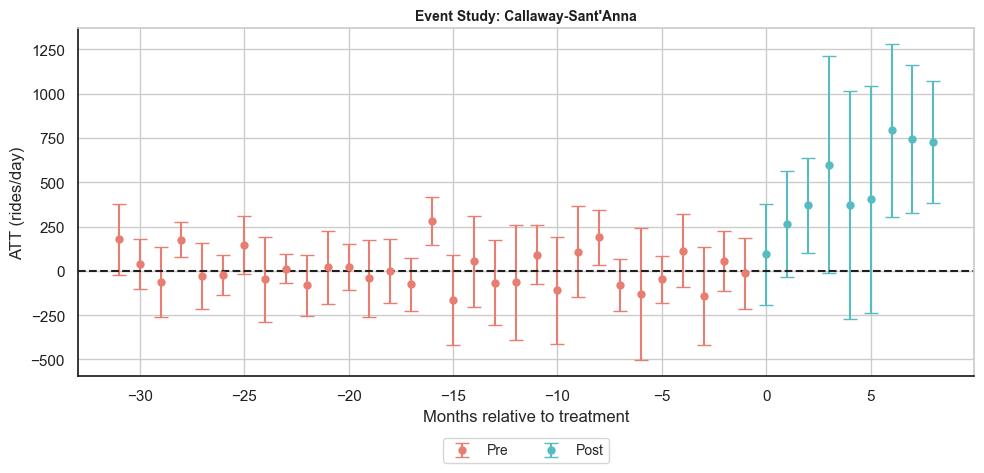

<Figure size 640x480 with 0 Axes>

In [9]:
# Event study plot
try:
    model.aggte(typec="dynamic", na_rm=True)
    model.plot_aggte(
        title="Event Study: Callaway-Sant'Anna",
        ylab="ATT (rides/day)",
        xlab="Months relative to treatment",
    )
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"Built-in plot failed: {e}")
    print("See tabular results above.")



Overall summary of ATT's based on group/cohort aggregation:
     ATT Std. Error   [95.0%  Conf. Int.]  
484.6878   126.1955 237.3491     732.0264 *


Group Effects:
   Group  Estimate  Std. Error  [95.0% Simult.   Conf. Band   
0  24303  371.8336    117.6318         141.2796    602.3876  *
1  24306  431.3873    395.6245        -344.0224   1206.7969   
2  24309  763.6966    250.0512         273.6052   1253.7881  *
---
Signif. codes: `*' confidence band does not cover 0
Control Group:  None , 
Anticipation Periods:  0
Estimation Method:  Outcome Regression




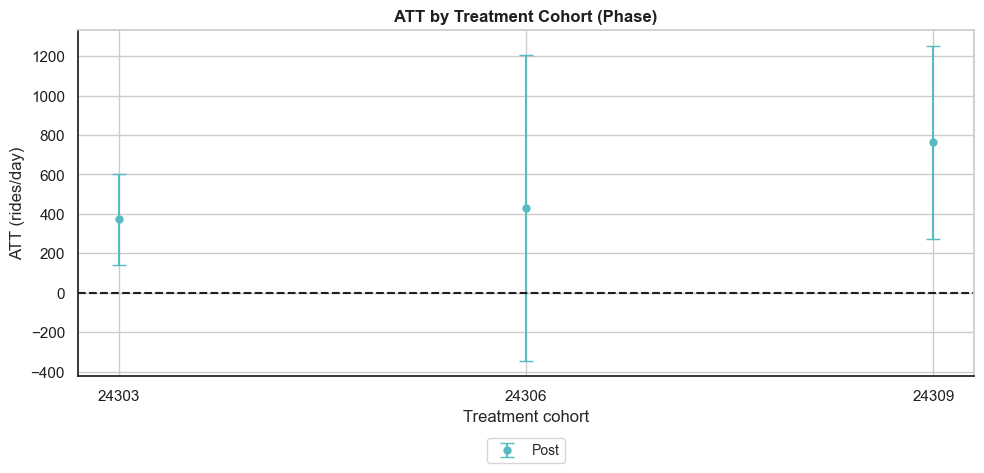

<Figure size 640x480 with 0 Axes>

In [10]:
# Group-level ATT plot
try:
    model.aggte(typec="group", na_rm=True)
    model.plot_aggte(
        title="ATT by Treatment Cohort (Phase)",
        ylab="ATT (rides/day)",
        xlab="Treatment cohort",
    )
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"Built-in plot failed: {e}")
    print("See tabular results above.")

## Summary

The Callaway-Sant'Anna estimator properly handles the staggered rollout by:
- Using only **never-treated** routes as the comparison group
- Computing separate ATTs for each cohort (phase) at each time period
- Aggregating with proper weighting

**Compare to naive pooled DiD:** The naive 2x2 estimate was -4.6%. The C-S overall ATT may differ because it avoids contamination from already-treated routes serving as implicit controls.

**Limitations:**
- Small number of units (20 treated + 20 control routes)
- Phase 4 has no post-data — excluded from ATT computation
- Phase 2/3 launch dates are approximate
- Monthly aggregation loses within-month variation